# Bitmex Analysis

In [1]:
# import libraries
import ccxt
import time

import numpy as np
import pandas as pd
import calendar
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

from tensorflow import keras
from sklearn import linear_model

# Jupyterを利用していたら、以下のおまじないを書くとnotebook上に図が表示
%matplotlib inline

- 本番用
       'apiKey': 'RR40xxve7kWPcwh6HUiJP7jX',
       'secret': 'sCymtpUSnZkSCP_shOKy5CArW41oGsB9a118_DmZsplkrjvC',
        
- test
       'apiKey': 'z5nYzkF_6drLZ8s5uQKJkS6y',
       'secret': 'EkVXpJk-5_LUMn9xWSETzVQPuUiwzgtTH4s7AUcMCEDr3eH0',

In [2]:
def bitmex(): #CCXT を呼び出す関数

   bitmex = ccxt.bitmex({

       #APIキー
       'apiKey': 'RR40xxve7kWPcwh6HUiJP7jX',
       'secret': 'sCymtpUSnZkSCP_shOKy5CArW41oGsB9a118_DmZsplkrjvC',

       })

   # bitmex.urls['api'] = bitmex.urls['test'] # test

   return(bitmex)

# Import Dataset

## Past Dataset

In [2]:
# ダウンロードしたデータをインポート
df = pd.read_csv('./btc_hist.csv', header=None)
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

df = df.set_index('datetime', drop=True)

In [3]:
# 分足リターンの計算
tf = 3

df['price_vol'] = df['close'].rolling(window=60).std()
df['return'] = df.pct_change()['close']
df['future_return'] = df.pct_change(tf)['close'].shift(-tf)

## Current Dataset

サーバーから最新のものを取得する（ただし、1000分まで)

In [143]:
latest_order_book = bitmex().fetch_order_book(symbol='BTC/USD')

In [144]:
# 取ってくるデータのパラメーター
now = datetime.utcnow() # 現在時刻(UTC)
minutes = 1000
unixtime = calendar.timegm(now.utctimetuple()) # Unix時間に変換
since = (unixtime - 60 * minutes) * 1000  # 10分前のUnix時間算出→ms単位に変換

# データを取得
df_now = pd.DataFrame(bitmex().fetch_ohlcv('BTC/USD', "1m", since, limit=minutes)) #10分前からの1分足情報を取得
df_now.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

# 日付に直す
df_now['datetime'] = list(map(datetime.fromtimestamp, df_now['datetime']/1000))
df_now = df_now.set_index('datetime', drop=True)

# Explanatory Data Analysis

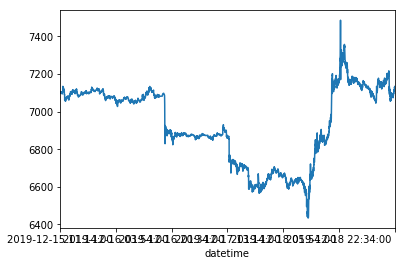

In [47]:
df['close'].plot()

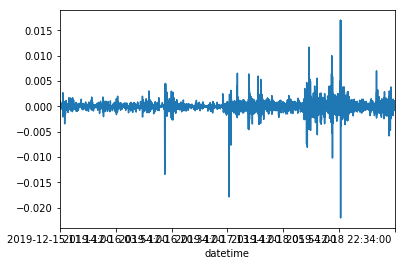

In [48]:
df['return'].plot()

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


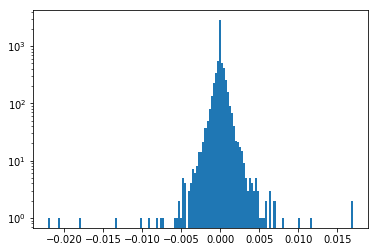

In [49]:
plt.hist(df['return'], log=True, bins=150)
plt.show()

# Feature Creation

## Price Type Features

### Mean reversion

定義の仕方：
1. $i$期間前の価格の変化率。
2. 直近$i$期間の、全てのリターンの符号。
3. 直近$i$期間の、全てのリターンの平均が正。

今回は1でやってみる。

ハイパーパラメーター：

- $i$: 平均をとる期間

In [38]:
# Mean reversion
for i in range(2,30):
    name = 'reversion1_' + str(i)
    name1 = 'reversion2_' + str(i)
    df[name] = -1 * df['close'].rolling(window=i).apply(lambda x:(x[-1] - x[0])/x[0], raw=True)
    df[name1] = -1 * df['return'].rolling(window=i).mean()

### Momentum

定義の仕方：
1. $i$期間前の価格の変化率
2. 直近$i$期間の、全てのリターンの平均。
3. 直近$i$期間の、全てのリターンの符号。

今回は1,2でやってみる。

ハイパーパラメーター：

- $i$: 平均をとる期間

In [39]:
# Momentum

for i in range(2,30):
    name = 'momentum1_' + str(i)
    name1 = 'momentum2_' + str(i)
    df[name] = df['close'].rolling(window=i).apply(lambda x:(x[-1] - x[0])/x[0], raw=True)
    df[name1] = df['return'].rolling(window=i).mean()

### (Historical) Volatility

条件付きの変数として用いる。MomentumとMean Reversionの一つの見分け方として、Historical Volatility$\sigma$がある。
Mean reversionの期間では、リターンの正負が入れ替わるが故に、その標準偏差が(モメンタムに比べて相対的に)大きくなる。モメンタムの場合は、リターンが一定の値になりやすいと考えられるので、標準偏差が相対的に小さくなると考えられる。

定義の仕方：

1. 過去$T_{past}$分間のボラ$\sigma_{past}$と、直近$T_{previous}$分間のリターンのボラ$\sigma_{prev}$の比: $\sigma_{past}/\sigma_{prev}$
2. 

ハイパーパラメーター：

- $T_{past}$: ベンチマークとなるVolatilityの期間。
- $T_{previous}$: 現在のマーケット環境とみなすVolatilityの期間

def check_momentum(data):
    q10 = np.quantile(data, 0.1) # 10% quantile point
    q25 = np.quantile(data, 0.3) # 25% quantile point
    q75 = np.quantile(data, 0.7) # 75% quantile point
    q90 = np.quantile(data, 0.9) # 90% quantile point
    state = 0

    if (data[-1] < q10) or (data[-1] > q90):
        state = 1 # Momentrum regime
    else:
        if ( q10 < data[-1]) and (data[-1] < q25):
            state = 0 # Mean reversion
        elif (q75 < data[-1]) and (data[-1] < q90):
            state = 0 # Mean reversion
        else:
            state = 1 # Momentrum regime

    return(state)

In [40]:
def check_momentum(data):
    q25 = np.quantile(data, 0.25) # 25% quantile point
    q75 = np.quantile(data, 0.75) # 75% quantile point
    state = 0

    if (data[-1] < q25) or (data[-1] > q75):
        state = 1 # Momentrum regime
    else:
        state = 0 # mean reversion regime

    return(state)

In [41]:
T_prev = 60

# Past Historical  Volatility
df['vol_return_prev'] = df['return'].rolling(T_prev).std().values
df['avg_voldiff'] = df['vol_return_prev'].pct_change().rolling(window=5).mean()
df['condition'] = df['vol_return_prev'].rolling(T_prev).apply(check_momentum)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [42]:
# Momentum
T_past = 120

# Previous Historical Volatility
df['vol_return_past'] = df['return'].rolling(T_past).std().values

# Conditionars
df['vol_ratio'] = df['vol_return_prev'] / df['vol_return_past']

ボラティリティ・クラスタリングが見て取れる。


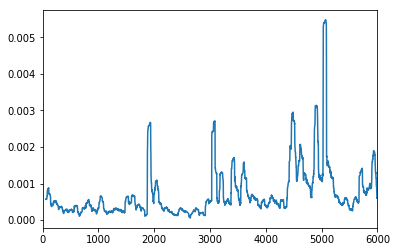

In [43]:
df['vol_return_prev'].plot()

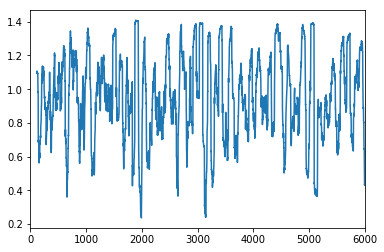

In [44]:
df['vol_ratio'].plot()

以下の図から、（この定義に基づくと）ほとんどモメンタムの状態であることがわかる。

将来リターンと過去のリターンの相関係数が負であることを考えると、平均回帰の状況で投資を行う方が期待リターンが高いことがわかる。

In [45]:
df.groupby('condition').apply(lambda x:len(x))

condition
0.0    1328
1.0    4553
dtype: int64

### Support and Resitance line (Condition variable)

レンジ相場において、有効な指標と考えられる。

60分前から、1分手前までの最低価格を更新したかどうか。
ブレイクしたなら、下がっていくと予想される（期待リターンはマイナス）。

60分前から、1分手前までの最高価格を更新したかどうか。
ブレイクしたなら、上がっていくと予想される（期待リターンはプラス）。

In [46]:
def to_extreme_index(x):
    
    extreme_index = 0
    
    if (x[0] <= x[1]) and ( x[2] <= x[1]):
        extreme_index = 1
    elif (x[0] >= x[1]) and ( x[2] >= x[1]):
        extreme_index = -1

    return(extreme_index)

In [47]:
df['extreme_index'] = df['close'].rolling(3, center=True).\
apply(to_extreme_index, raw=True)
df['extreme_value'] = df['close'] * df['extreme_index']

In [48]:
T = 60

df['lowest_60min'] = df['extreme_value'].shift(1).rolling(T)\
.apply(lambda x: abs(x.min()), raw=True)
df['highest_60min'] = df['extreme_value'].shift(1).rolling(T).max()

# 特徴量に変換。
df['support_feature'] = (df['close'] - df['lowest_60min']) / (2 * df['price_vol'])
df['resitance_feature'] = - (df['highest_60min'] - df['close']) / (2 * df['price_vol'])

## Volume Type Features

### Volume Ratio on Order Book 

現在の板にある、売りの量$V_{sell}$と買い$V_{buy}$の注文量の割合$V_{r} = \frac{V_{sell}}{V_{buy}}$を計算する。あまりにも$V_{r}$が大きいと、売り圧力が強いことになり、価格は下がると考えられる（ショートすれば儲かる）。逆の場合は、価格が上がると考えられ、ロングすれば儲かることになる。重要なことであるが、この特徴量は価格の情報を一切用いていないので、価格より生成される特徴量とは独立なものである。

ハイパーパラメーター：

- $\Delta$: どの値幅で注文の量を計算するか

ただ、大きな問題としてBitMexには時系列の板情報が存在しない？ため、バックテストができないことがある。

In [578]:
bids = np.array(latest_order_book['bids'])
asks = np.array(latest_order_book['asks'])

NameError: name 'latest_order_book' is not defined

In [61]:
INT_DETLA = int(2 / 0.5)

In [62]:
bids[:INT_DETLA,1].sum()

1192019.0

In [63]:
asks[:INT_DETLA,1].sum()

2299674.0

### Effective Volume Sum

初めに、過去の1分足データで、出来高に価格の始値と終値の差をかけた量を計算する($V_{index}$とする)。過去$n$分の$V_{index}$の総和を取り、その和があまりにも大きいと、過去に大きな買いの圧力があったことを表すので、(投資家達は投機目的で投資しており、いつかポジションを解消するということ)平均回帰すると仮定すると、どこかでその注文を取り消すような大きな売りが入る可能性があることを表す。つまり、この仮定の下ではショートすれば儲かる。逆もしかり。

\begin{equation}
V_{sum,t} = \sum^{i=n}_{i=1} V_{index,t-i}
\end{equation}

この量と将来リターンが負の相関を持つことが期待される。

In [49]:
# だいたい1時間で(=90min)で、極端なポジションは解消されるとする。
HVOL_MINUTES = 90

In [50]:
# Calculate effective volume
df['eff_volume'] = (df['open'] - df['close']) * df['volume']
df['eff_volume'] = df['eff_volume'].rolling(window=HVOL_MINUTES).sum()

# Normalized effective volume
df['norm_eff_volume'] = df['eff_volume'] / (df['eff_volume'].quantile(0.75) \
                                                      - df['eff_volume'].quantile(0.25) )

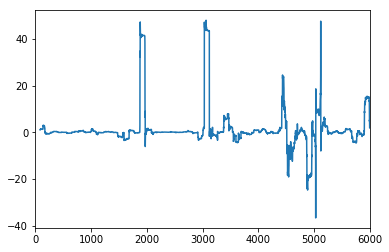

In [51]:
df['norm_eff_volume'].plot()

# Samling (Restrict to in-sample Only)

In [52]:
df = df.reset_index()

In [53]:
# Parameter for Sampling
interval_min = 120

In [54]:
# Sampling
df['future_return'] = df['future_return'].where(df.index // interval_min % 2 == 0)
df['future_index'] = df['future_index'].where(df.index // interval_min % 2 == 0)

For validation dataset

# Evaluation on In-Sample data

## Without Conditioning Variable

In [55]:
RESPONCE = 'future_return'

### Mean reversion

In [56]:
corr_nocondition = df.corr()

In [57]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: blue' if v else '' for v in is_max]

平均回帰の場合は、直近のリターンを見るのが良い。1でも2でも同じ。

In [58]:
pd.DataFrame(corr_nocondition[RESPONCE][list(map(lambda x: 'reversion1' in x, corr_nocondition.index))])\
.style.apply(highlight_max)

,future_return
reversion1_2,0.0737639
reversion1_3,0.057732
reversion1_4,0.0315802
reversion1_5,0.018627
reversion1_6,0.0299708
reversion1_7,0.021608
reversion1_8,0.0147708
reversion1_9,0.0108798
reversion1_10,0.00571957
reversion1_11,-0.0141903


In [59]:
pd.DataFrame(corr_nocondition[RESPONCE][list(map(lambda x: 'reversion2' in x, corr_nocondition.index))])\
.style.apply(highlight_max)

,future_return
reversion2_2,0.057808
reversion2_3,0.0317122
reversion2_4,0.0187467
reversion2_5,0.0299941
reversion2_6,0.0216316
reversion2_7,0.0147375
reversion2_8,0.0107422
reversion2_9,0.00564385
reversion2_10,-0.0141611
reversion2_11,-0.0348191


### Momentum

モメンタムの場合は、だいたい10分前のリターンを見るのが良い。1でも2でも同じ。

In [60]:
pd.DataFrame(corr_nocondition[RESPONCE][list(map(lambda x: 'momentum1' in x, corr_nocondition.index))])\
.style.apply(highlight_max)

,future_return
momentum1_2,-0.0737639
momentum1_3,-0.057732
momentum1_4,-0.0315802
momentum1_5,-0.018627
momentum1_6,-0.0299708
momentum1_7,-0.021608
momentum1_8,-0.0147708
momentum1_9,-0.0108798
momentum1_10,-0.00571957
momentum1_11,0.0141903


In [61]:
pd.DataFrame(corr_nocondition[RESPONCE][list(map(lambda x: 'momentum2' in x, corr_nocondition.index))])\
.style.apply(highlight_max)

,future_return
momentum2_2,-0.057808
momentum2_3,-0.0317122
momentum2_4,-0.0187467
momentum2_5,-0.0299941
momentum2_6,-0.0216316
momentum2_7,-0.0147375
momentum2_8,-0.0107422
momentum2_9,-0.00564385
momentum2_10,0.0141611
momentum2_11,0.0348191


### Support and Resistance Line

In [62]:
display(corr_nocondition[RESPONCE]['support_feature'])
display(corr_nocondition[RESPONCE]['resitance_feature'])

0.05058857684407429

0.005867023532589816

### Historical Volatility

In [63]:
corr_nocondition[RESPONCE]['vol_return_past']

-0.0037555468988481598

In [64]:
corr_nocondition[RESPONCE]['vol_ratio']

0.021058177917960084

### Effective Volume Sum

In [65]:
corr_nocondition[RESPONCE]['norm_eff_volume']

-0.045872270067930064

## Create Predictors

In [66]:
FEATURES = ['reversion1_2', 'momentum1_13', 'support_feature', 'resitance_feature', \
           'vol_return_past', 'vol_ratio', 'norm_eff_volume']

### Linear Regression

基本的にショートになるはずなので、切片は負であるべき。以下の回帰の結果では、そのようになっている。

In [67]:
clf = linear_model.LinearRegression()

data = df[[RESPONCE] + FEATURES].dropna()
x = data[FEATURES].values
y = data[RESPONCE].values

clf.fit(x, y) # 予測モデルを作成
y_pred = clf.predict(x)
data['predictor'] = clf.predict(x)

# 散布図
print(clf.coef_)
print(clf.intercept_)

[ 1.51758274e-01  2.07613149e-02  4.15530043e-04 -3.81391651e-04
 -7.04310371e-02  4.32481634e-05 -9.40138584e-06]
-9.536479480115145e-05


残差は比較的ランダムに分布しているように見える。?

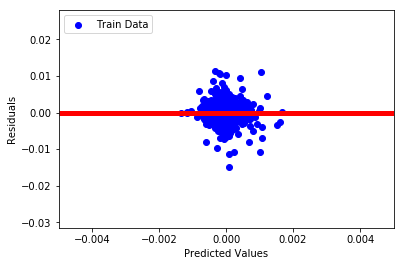

In [68]:
# 学習用、検証用それぞれで残差をプロット
plt.scatter(y_pred, y_pred - y, c = 'blue', marker = 'o', label = 'Train Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
# 凡例を左上に表示
plt.legend(loc = 'upper left')
# y = 0に直線を引く
plt.hlines(y = 0, xmin = -0.005, xmax = 0.005, lw = 5, color = 'red')
plt.xlim([-0.005, 0.005])
plt.show()

#### Performance

In [69]:
performance = (data[RESPONCE]  * data['predictor']).groupby(data.index).sum(min_count=1) 

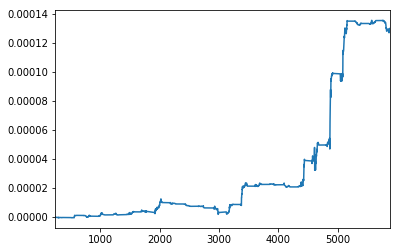

In [70]:
performance.cumsum().plot()

In [78]:
total_num = len(performance)
hit_num = (performance > 0).sum()
hit_ratio = hit_num / total_num

display('Hit ratio is {}%.'.format(round(hit_ratio*100, 2)))

'Hit ratio is 45.52%.'

### Deep Neural Net

#### Cross Validation

##### 目的変数が実数値の場合

- 2 fold

In [126]:
## Train and Validation data split
df_train = df.copy()
df_val = df.copy()
df_train['future_return'] = df_train['future_return'].where(df_train.index // 60 % 2 == 0)
df_val['future_return'] = df_val['future_return'].where(df_val.index // 60 % 2 == 1)

In [127]:
RESPONCE = 'future_return'

In [128]:
# Train data
data_train = df_train[[RESPONCE] + FEATURES].dropna()
x_train = data_train[FEATURES].values
y_train = data_train[RESPONCE].values

# Validation data
data_val = df_val[[RESPONCE] + FEATURES].dropna()
x_val = data_val[FEATURES].values
y_val = data_val[RESPONCE].values

In [129]:
learning_rate = 0.01
epochs = 200
batch_size = 64

In [130]:
import keras.backend as K

def sharpe_ratio(y_true, y_pred):
    sharpe_ratio =  K.sum(y_pred * y_true) * batch_size
    return(sharpe_ratio)

Using TensorFlow backend.


In [131]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, adam


# モデルの作成
model = Sequential()

# モデルにレイヤーを積み上げていく
model.add(Dense(units=10, input_dim=7))
model.add(Activation('relu'))
model.add(Dense(units=10))
model.add(Activation('relu'))
model.add(Dense(units=1))
model.add(Activation('linear'))

model.compile(loss = 'mean_squared_error',  optimizer=adam(lr=learning_rate),\
             metrics=[sharpe_ratio])

Instructions for updating:
Colocations handled automatically by placer.


In [132]:
# 訓練の実行
result = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1440 samples, validate on 1440 samples
Epoch 1/200
1440/1440 [==============================] - 1s 392us/step - loss: 0.3474 - sharpe_ratio: 0.0948 - val_loss: 0.0338 - val_sharpe_ratio: 0.0180
Epoch 2/200
1440/1440 [==============================] - 0s 35us/step - loss: 0.0101 - sharpe_ratio: 0.0151 - val_loss: 0.0057 - val_sharpe_ratio: 0.0135
Epoch 3/200
1440/1440 [==============================] - 0s 40us/step - loss: 0.0034 - sharpe_ratio: -0.0072 - val_loss: 0.0033 - val_sharpe_ratio: 0.0028
Epoch 4/200
1440/1440 [==============================] - 0s 47us/step - loss: 0.0020 - sharpe_ratio: -0.0018 - val_loss: 0.0028 - val_sharpe_ratio: -9.3275e-04
Epoch 5/200
1440/1440 [==============================] - 0s 43us/step - loss: 0.0016 - sharpe_ratio: 3.6775e-05 - val_loss: 0.0024 - val_sharpe_ratio: -7.2639e-04
Epoch 6/200
1440/1440 [==============================] - 0s 44us/step - loss: 0.0013 - sharpe_ratio: -7.5339e-04 - va

In [133]:
def plot_metrics(Result, metrics_name, epoch):
    
    if metrics_name == 'loss':
        plt.plot(range(1, epoch+1), np.log(Result.history[metrics_name]), label="training")
        plt.plot(range(1, epoch+1), np.log(Result.history['val_'+metrics_name]), label="validation")
    else:
        plt.plot(range(1, epoch+1), Result.history[metrics_name], label="training")
        plt.plot(range(1, epoch+1), Result.history['val_'+metrics_name], label="validation")
        
    plt.xlabel('Epochs')
    plt.ylabel(metrics_name)
    plt.legend()

    plt.show()

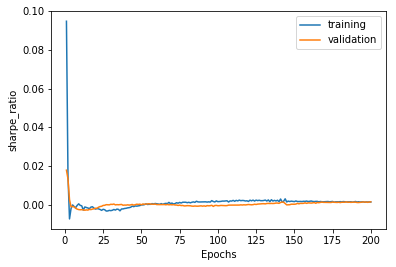

In [134]:
plot_metrics(result, 'sharpe_ratio', epochs)

In [135]:
display(result.history['sharpe_ratio'][-1])
display(result.history['val_sharpe_ratio'][-1])

0.0015421962611273758

0.001632171372895957

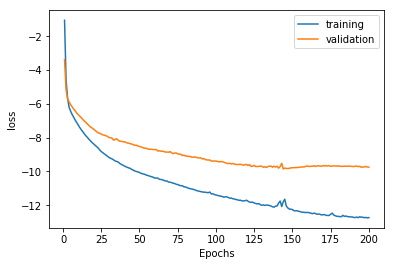

In [136]:
plot_metrics(result, 'loss', epochs)

#### Peformance

学習を重ねると、予測がほぼ一定値になってしまうという問題がある。

In [137]:
predict_NN = model.predict(x)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1327c7410>]],
      dtype=object)

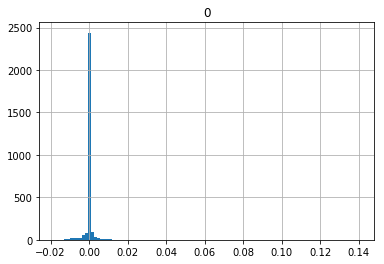

In [138]:
pd.DataFrame(predict_NN).hist(bins=100)

In [139]:
# 予測の評価
data['predictor_NN'] = model.predict(x)

In [140]:
performance_NN = (data[RESPONCE]  * data['predictor_NN']).groupby(data.index).sum(min_count=1) 

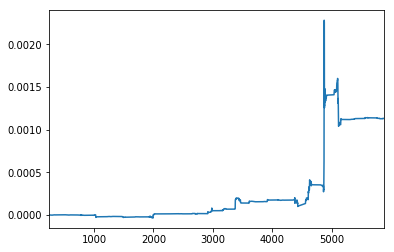

In [141]:
performance_NN.cumsum().plot()

分位点によって、離散値へ変換し、パフォーマンスを計測する。

In [142]:
min_q = 0.2
max_q = 0.8

In [143]:
quantile_predictor = data['predictor_NN'].quantile([min_q, max_q])

In [144]:
def to_side(x, lower, higher):
    side = 0
    if x>higher:
        side = 1
    elif x<lower:
        side = -1
    return(side)

In [145]:
data['predictor_NN_quantile'] = data['predictor_NN'].\
apply(lambda x: to_side(x, quantile_predictor[min_q], quantile_predictor[max_q]))

In [146]:
performance_NN_qtile= (data[RESPONCE]  * data['predictor_NN_quantile']).\
groupby(data.index).sum(min_count=1) 

良さそうに見えるが、まだ真に予測性能を持っているかはわからない。そこで、以下のように4fold validatonを行う。
(本当にこれで正しく予測性能を計れている？リークの問題はどうなっている？？)

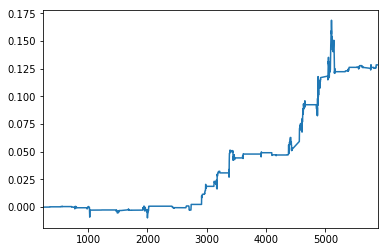

In [147]:
performance_NN_qtile.cumsum().plot()

- 4 folds

In [148]:
def four_folds_validation(insample_data):
    
    minlist =[0,1,2,3]
    result = []
    i = 0
    
    for mins in tqdm(minlist):
        remain = list(set(minlist) - {mins})

        for rem in remain:
            
            data_train = insample_data.copy()
            data_val = insample_data.copy()
            data_train['future_return'] = data_train['future_return'].\
            where(data_train.index // 30 % 4 == mins)
            data_val['future_return'] = data_val['future_return'].\
            where(data_val.index // 30 % 4 == rem)
            
            sharpe_ratio = validation(data_train ,data_val)
            result.append(['CV_'+str(i), sharpe_ratio])
            print(result)
            i = i + 1
            
    return(result)            

In [149]:
def validation(data_train, data_val):

    data_train = data_train[[RESPONCE] + FEATURES].dropna()
    x_train = data_train[FEATURES].values
    y_train = data_train[RESPONCE].values

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
    

    data_val = data_val[[RESPONCE] + FEATURES].dropna()
    x_val = data_val[FEATURES].values
    y_val = data_val[RESPONCE].values
    data_val['predictor'] = model.predict(x_val)
    
    quantile_predictor = data_val['predictor'].quantile([min_q, max_q])
    
    data_val['predictor_quantile'] = data['predictor'].\
    apply(lambda x: to_side(x, quantile_predictor[min_q], quantile_predictor[max_q]))
    
    performance_val =  (data_val[RESPONCE]  * data_val['predictor_quantile']).\
    groupby(data_val.index).sum(min_count=1) 
    
    sharpe_ratio = performance_val.mean() / performance_val.std()
    
    return(sharpe_ratio)

In [150]:
CV_sharpe = four_folds_validation(df)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/200
720/720 [==============================] - 0s 33us/step - loss: 2.2914e-06 - sharpe_ratio: 0.0015
Epoch 2/200
720/720 [==============================] - 0s 29us/step - loss: 2.2711e-06 - sharpe_ratio: 0.0013
Epoch 3/200
720/720 [==============================] - 0s 33us/step - loss: 2.0520e-06 - sharpe_ratio: 0.0014
Epoch 4/200
720/720 [==============================] - 0s 40us/step - loss: 2.0279e-06 - sharpe_ratio: 0.0015
Epoch 5/200
720/720 [==============================] - 0s 31us/step - loss: 2.1676e-06 - sharpe_ratio: 0.0017
Epoch 6/200
720/720 [==============================] - 0s 35us/step - loss: 2.0142e-06 - sharpe_ratio: 0.0013
Epoch 7/200
720/720 [==============================] - 0s 27us/step - loss: 1.9375e-06 - sharpe_ratio: 0.0016
Epoch 8/200
720/720 [==============================] - 0s 34us/step - loss: 1.9617e-06 - sharpe_ratio: 0.0016
Epoch 9/200
720/720 [==============================] - 0s 35us/step - loss: 1.9045e-06 - sharpe_ratio: 0.0015
Epoch 10/2

 25%|██▌       | 1/4 [00:19<00:57, 19.33s/it]

[['CV_0', 0.0786594286367428], ['CV_1', 0.017504106712474102], ['CV_2', -0.03817176754915585]]
Epoch 1/200
720/720 [==============================] - 0s 28us/step - loss: 3.0127e-06 - sharpe_ratio: 0.0012
Epoch 2/200
720/720 [==============================] - 0s 54us/step - loss: 3.1708e-06 - sharpe_ratio: 0.0013
Epoch 3/200
720/720 [==============================] - 0s 35us/step - loss: 2.3368e-06 - sharpe_ratio: 0.0016
Epoch 4/200
720/720 [==============================] - 0s 33us/step - loss: 2.2015e-06 - sharpe_ratio: 0.0017
Epoch 5/200
720/720 [==============================] - 0s 29us/step - loss: 2.3198e-06 - sharpe_ratio: 0.0012
Epoch 6/200
720/720 [==============================] - 0s 44us/step - loss: 2.1935e-06 - sharpe_ratio: 0.0023
Epoch 7/200
720/720 [==============================] - 0s 43us/step - loss: 3.6133e-06 - sharpe_ratio: 8.2400e-04
Epoch 8/200
720/720 [==============================] - 0s 44us/step - loss: 3.4174e-06 - sharpe_ratio: 9.2035e-04
Epoch 9/200
720/7

 50%|█████     | 2/4 [00:36<00:37, 18.72s/it]

[['CV_0', 0.0786594286367428], ['CV_1', 0.017504106712474102], ['CV_2', -0.03817176754915585], ['CV_3', 0.01597259638314207], ['CV_4', 0.03291135006657285], ['CV_5', 0.04262370539615789]]
Epoch 1/200
720/720 [==============================] - 0s 26us/step - loss: 4.0680e-06 - sharpe_ratio: 1.4315e-04
Epoch 2/200
720/720 [==============================] - 0s 33us/step - loss: 3.3111e-06 - sharpe_ratio: 5.0666e-04
Epoch 3/200
720/720 [==============================] - 0s 32us/step - loss: 3.9217e-06 - sharpe_ratio: 1.8879e-04
Epoch 4/200
720/720 [==============================] - 0s 36us/step - loss: 4.2178e-06 - sharpe_ratio: 4.0267e-04
Epoch 5/200
720/720 [==============================] - 0s 35us/step - loss: 3.7563e-06 - sharpe_ratio: 1.6997e-04
Epoch 6/200
720/720 [==============================] - 0s 41us/step - loss: 3.7251e-06 - sharpe_ratio: -1.0943e-04
Epoch 7/200
720/720 [==============================] - 0s 38us/step - loss: 3.3321e-06 - sharpe_ratio: -1.1630e-05
Epoch 8/200


 75%|███████▌  | 3/4 [00:54<00:18, 18.56s/it]

[['CV_0', 0.0786594286367428], ['CV_1', 0.017504106712474102], ['CV_2', -0.03817176754915585], ['CV_3', 0.01597259638314207], ['CV_4', 0.03291135006657285], ['CV_5', 0.04262370539615789], ['CV_6', 0.03489394128816572], ['CV_7', 0.027529901660917046], ['CV_8', 0.06054735949589045]]
Epoch 1/200
720/720 [==============================] - 0s 30us/step - loss: 8.5305e-06 - sharpe_ratio: -1.0493e-04
Epoch 2/200
720/720 [==============================] - 0s 36us/step - loss: 2.5362e-06 - sharpe_ratio: 1.5657e-04
Epoch 3/200
720/720 [==============================] - 0s 34us/step - loss: 2.0482e-06 - sharpe_ratio: -7.6463e-05
Epoch 4/200
720/720 [==============================] - 0s 35us/step - loss: 2.1606e-06 - sharpe_ratio: -8.4404e-05
Epoch 5/200
720/720 [==============================] - 0s 38us/step - loss: 3.4003e-06 - sharpe_ratio: 2.4610e-06
Epoch 6/200
720/720 [==============================] - 0s 35us/step - loss: 3.5056e-06 - sharpe_ratio: -3.9770e-04
Epoch 7/200
720/720 [=========

100%|██████████| 4/4 [01:12<00:00, 18.25s/it]

[['CV_0', 0.0786594286367428], ['CV_1', 0.017504106712474102], ['CV_2', -0.03817176754915585], ['CV_3', 0.01597259638314207], ['CV_4', 0.03291135006657285], ['CV_5', 0.04262370539615789], ['CV_6', 0.03489394128816572], ['CV_7', 0.027529901660917046], ['CV_8', 0.06054735949589045], ['CV_9', 0.03050881947395549], ['CV_10', 0.03568302471967764], ['CV_11', 0.08697677366872884]]


以下が12回のCross Validationの下での平均リターンである。正になっていることから、予測性能があることがわかる。

In [152]:
pd.DataFrame(CV_sharpe)

,0,1
0,CV_0,0.078659
1,CV_1,0.017504
2,CV_2,-0.038172
3,CV_3,0.015973
4,CV_4,0.032911
5,CV_5,0.042624
6,CV_6,0.034894
7,CV_7,0.027530
8,CV_8,0.060547
9,CV_9,0.030509


In [151]:
pd.DataFrame(CV_sharpe)[1].mean()

0.03546993666277242

- 目的変数が離散値の場合


うまく学習ができないという問題がある。ノイズが強すぎるせい？

In [906]:
RESPONCE = 'future_index'

In [907]:
df_train[RESPONCE] = df_train[RESPONCE].where(df_train.index // 60 % 2 == 0)
df_val[RESPONCE] = df_val[RESPONCE].where(df_val.index // 60 % 2 == 1)

In [908]:
# Train data
data_train = df_train[[RESPONCE] + FEATURES].dropna()
x_train = data_train[FEATURES].values
y_train = data_train[RESPONCE].values

# Validation data
data_val = df_val[[RESPONCE] + FEATURES].dropna()
x_val = data_val[FEATURES].values
y_val = data_val[RESPONCE].values

In [909]:
from keras.utils import np_utils

# ラベルをone-hot-encoding形式に変換
y_train_index = np_utils.to_categorical(y_train)
y_val_index = np_utils.to_categorical(y_val)

In [910]:
learning_rate = 0.025
epochs = 200
batch_size = 32

In [911]:
# モデルの作成
model_index = Sequential()

# モデルにレイヤーを積み上げていく
model_index.add(Dense(units=10, input_dim=7))
model_index.add(Activation('relu'))
model_index.add(Dense(units=10))
model_index.add(Activation('relu'))
model_index.add(Dense(units=3))
model_index.add(Activation('softmax'))

model_index.compile(loss = 'categorical_crossentropy',  optimizer=adam(lr=learning_rate),\
             metrics=['accuracy'])

In [912]:
# 訓練の実行
result_index = model_index.fit(x_train, y_train_index, epochs=epochs,\
                               batch_size=batch_size, validation_data=(x_val, y_val_index))

Train on 1440 samples, validate on 1440 samples
Epoch 1/200
1440/1440 [==============================] - 29s 20ms/step - loss: 1.0127 - acc: 0.5146 - val_loss: 1.0305 - val_acc: 0.5056
Epoch 2/200
1440/1440 [==============================] - 1s 433us/step - loss: 0.9773 - acc: 0.5382 - val_loss: 1.0166 - val_acc: 0.5132
Epoch 3/200
1440/1440 [==============================] - 1s 430us/step - loss: 0.9639 - acc: 0.5542 - val_loss: 1.0201 - val_acc: 0.4833
Epoch 4/200
1440/1440 [==============================] - 1s 635us/step - loss: 0.9562 - acc: 0.5465 - val_loss: 1.0312 - val_acc: 0.5035
Epoch 5/200
1440/1440 [==============================] - 1s 430us/step - loss: 0.9596 - acc: 0.5556 - val_loss: 1.0278 - val_acc: 0.4854
Epoch 6/200
1440/1440 [==============================] - 1s 425us/step - loss: 0.9525 - acc: 0.5563 - val_loss: 1.0165 - val_acc: 0.5139
Epoch 7/200
1440/1440 [==============================] - 1s 384us/step - loss: 0.9479 - acc: 0.5618 - val_loss: 1.0136 - val_acc: 

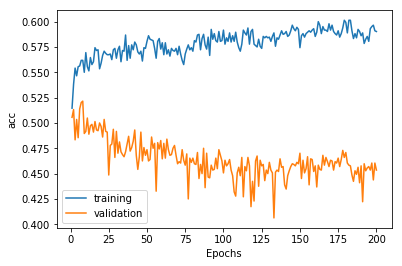

In [913]:
plot_metrics(result_index, 'acc', epochs)

In [914]:
display(result_index.history['acc'][-1])
display(result_index.history['val_acc'][-1])

0.5902777777777778

0.4534722222222222

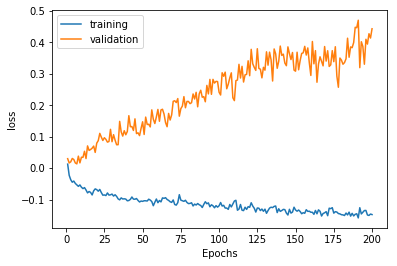

In [915]:
plot_metrics(result_index, 'loss', epochs)

#### Peformance

In [547]:
# 予測の評価
data['predictor_NN_index'] = model_index.predict(x)

In [548]:
performance_NN_index = (data[RESPONCE]  * data['predictor_NN_index']).groupby(data.index).sum(min_count=1) 

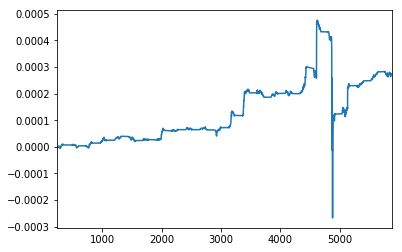

In [549]:
performance_NN_index.cumsum().plot()

## With Conditioning Variable of Regime Change

Type1の平均回帰だけは、相関が強くなった。あとは、ほんの少し変わったり、逆に弱くなったりという感じ。
あまり使えないかもしれない。

### Type 1

#### Mean Reversion

Correlation becomes stronger than that without the conditioning variable.

In [123]:
reversion_term = pd.DataFrame(df[df['vol_ratio'] > 1])
momentum_term = pd.DataFrame(df[df['vol_ratio'] < 1])

In [124]:
corr_rever = reversion_term.corr()

In [127]:
pd.DataFrame(corr_rever[RESPONCE][list(map(lambda x: 'reversion' in x, corr_rever.index))])\
.style.apply(highlight_max)

,future_return
reversion_2,0.0969168
reversion_3,0.0749309
reversion_4,0.0395741
reversion_5,0.02411
reversion_6,0.0423123
reversion_7,0.034767
reversion_8,0.0215766
reversion_9,0.0106069
reversion_10,-0.00119173


#### Momentum

This is different from our expectation. The term is not proper.

In [128]:
corr_momentum = momentum_term.corr()

In [137]:
pd.DataFrame(corr_momentum[RESPONCE][list(map(lambda x: 'momentum' in x, corr_momentum.index))])\
.style.apply(highlight_max)

,future_return
momentum_2,0.00323045
momentum_3,0.0112754
momentum_4,0.0220591
momentum_5,0.00302405
momentum_6,-0.0191438
momentum_7,-0.035133
momentum_8,-0.0323132
momentum_9,-0.0288294
momentum_10,-0.0232917


### Type2

#### Momentum

In [130]:
momentum_term2 = pd.DataFrame(df[df['avg_voldiff'] < 0])

In [131]:
corr_momentum2 = momentum_term2.corr()

In [133]:
pd.DataFrame(corr_momentum2[RESPONCE][list(map(lambda x: 'momentum' in x, corr_momentum2.index))])\
.style.apply(highlight_max)

,future_return
momentum_2,-0.0156064
momentum_3,-0.0185411
momentum_4,-0.0249423
momentum_5,-0.0583501
momentum_6,-0.0774098
momentum_7,-0.0388014
momentum_8,-0.0236168
momentum_9,-0.0255044
momentum_10,0.00692818


### Type 3

#### Mean reversion

In [139]:
reversion_term3 = pd.DataFrame(df[df['condition'] == 0])
corr_reversion3 = reversion_term3.corr()

In [140]:
pd.DataFrame(corr_reversion3[RESPONCE][list(map(lambda x: 'momentum' in x, corr_reversion3.index))])\
.style.apply(highlight_max)

,future_return
momentum_2,-0.0167545
momentum_3,-0.00327731
momentum_4,-0.0379374
momentum_5,-0.0563487
momentum_6,-0.0467666
momentum_7,-0.0393795
momentum_8,-0.0747682
momentum_9,-0.0562331
momentum_10,0.00657314


#### Momentum

In [134]:
momentum_term3 = pd.DataFrame(df[df['condition'] == 1])
corr_momentum3 = momentum_term3.corr()

In [136]:
pd.DataFrame(corr_condition_moment3[RESPONCE][list(map(lambda x: 'momentum' in x, corr_condition_moment3.index))])\
.style.apply(highlight_max)

,future_return
momentum_2,0.0228248
momentum_3,-0.00977536
momentum_4,0.00706438
momentum_5,0.0183027
momentum_6,0.020307
momentum_7,0.0247179
momentum_8,0.0590716
momentum_9,0.0825833
momentum_10,0.0793545
